In [1]:
import os

os.chdir("../../")

import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_handling import ingestion

sns.set_theme(context="paper", font_scale=1.15, style="whitegrid")

In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

Using cpu for training


In [3]:
ts_data = ingestion.read_combined().dropna()

d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
d:\anaconda3\envs\ba\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
X, y = ts_data, ts_data["consumption"].values
X.shape, y.shape

((2250, 9), (2250,))

In [5]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

Create sequences of 128 days of all regressors and then 14 days of fixed regressors and future
temperature values.

In [6]:
def create_sequences(X, y, n_steps_x, n_steps_y):
    Xs, ys = [], []
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + n_steps_x
        out_end_ix = end_ix + n_steps_y
        # check if we are beyond the dataset
        if out_end_ix > len(X):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = X[i:end_ix], y[end_ix:out_end_ix]

        # add feature to seq_x indicating that it is historic data
        seq_x = np.concatenate((seq_x, np.zeros((n_steps_x, 1))), axis=1)

        # append "future" temperature data to seq_x
        future_temperatures = np.zeros((n_steps_y, X.shape[1]))
        future_temperatures[:, -1] = X[end_ix:out_end_ix, 0]

        # add feature to future_temperatures indicating that it is future data
        future_temperatures = np.concatenate((future_temperatures, np.ones((n_steps_y, 1))), axis=1)

        # concatenate seq_x and future_temperatures
        seq_x = np.concatenate((seq_x, future_temperatures), axis=0)

        Xs.append(seq_x)
        ys.append(seq_y)
    return np.array(Xs), np.array(ys)

In [7]:
X_ss, y_mm = create_sequences(X_trans, y_trans, 256, 128)
X_ss.shape, y_mm.shape

((1867, 384, 10), (1867, 128, 1))

In [8]:
total_samples = X.shape[0]
train_test_cutoff = int(total_samples * 0.8)

X_train, X_test = X_ss[:train_test_cutoff], X_ss[train_test_cutoff:]
y_train, y_test = y_mm[:train_test_cutoff], y_mm[train_test_cutoff:]

print("Training shapes:", X_train.shape, y_train.shape)
print("Testing shapes:", X_test.shape, y_test.shape)

Training shapes: (1800, 384, 10) (1800, 128, 1)
Testing shapes: (67, 384, 10) (67, 128, 1)


In [9]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# (number of sequences, number of intances (days) per sequence, number of features in each instance)
print("Training Shape:", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors.shape, y_test_tensors.shape)

Training Shape: torch.Size([1800, 384, 10]) torch.Size([1800, 128, 1])
Testing Shape: torch.Size([67, 384, 10]) torch.Size([67, 128, 1])


In [16]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM model
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.01,
        )

        # Fully connected last layer
        self.fc = nn.Linear(hidden_size * num_layers, num_classes)

        self.tanh = nn.Tanh()

    def forward(self, x):
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(
            x
        )  # (input, hidden, and internal state)

        hn = hn.view(-1, self.hidden_size * self.num_layers)
        out = self.tanh(hn)
        out = self.fc(out)

        return out

In [11]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):

    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)  # forward pass
        optimiser.zero_grad()  # calculate the gradient, manually setting to 0

        # obstain the loss function
        loss = loss_fn(outputs, y_train.squeeze())
        loss.backward()  # calculate the loss of the loss function
        optimiser.step()  # improve from loss, i.e backdrop

        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test.squeeze())

        if epoch % 1 == 0:
            print(
                f"Epoch: {epoch}, train loss: {loss.item() :.6f}, test loss: {test_loss.item() :.6f}"
            )

In [17]:
n_epochs = 150
learning_rate = 0.001

input_size = 10
hidden_size = 50
num_layers = 1

num_classes = 128

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

d:\anaconda3\envs\ba\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [29]:
training_loop(
    70,
    lstm,
    optimiser,
    loss_fn,
    X_train_tensors,
    y_train_tensors,
    X_test_tensors,
    y_test_tensors,
)

Epoch: 0, train loss: 0.029459, test loss: 0.055378
Epoch: 1, train loss: 0.029286, test loss: 0.054911
Epoch: 2, train loss: 0.029108, test loss: 0.054656
Epoch: 3, train loss: 0.028929, test loss: 0.054537
Epoch: 4, train loss: 0.028754, test loss: 0.054458
Epoch: 5, train loss: 0.028590, test loss: 0.054308
Epoch: 6, train loss: 0.028434, test loss: 0.053994
Epoch: 7, train loss: 0.028278, test loss: 0.053464
Epoch: 8, train loss: 0.028115, test loss: 0.052723
Epoch: 9, train loss: 0.027940, test loss: 0.051837
Epoch: 10, train loss: 0.027759, test loss: 0.050901
Epoch: 11, train loss: 0.027579, test loss: 0.050013
Epoch: 12, train loss: 0.027401, test loss: 0.049245
Epoch: 13, train loss: 0.027216, test loss: 0.048620
Epoch: 14, train loss: 0.027016, test loss: 0.048104
Epoch: 15, train loss: 0.026799, test loss: 0.047609
Epoch: 16, train loss: 0.026571, test loss: 0.047020
Epoch: 17, train loss: 0.026334, test loss: 0.046233
Epoch: 18, train loss: 0.026078, test loss: 0.045199
Epo

Test loss: 0.008281940594315529


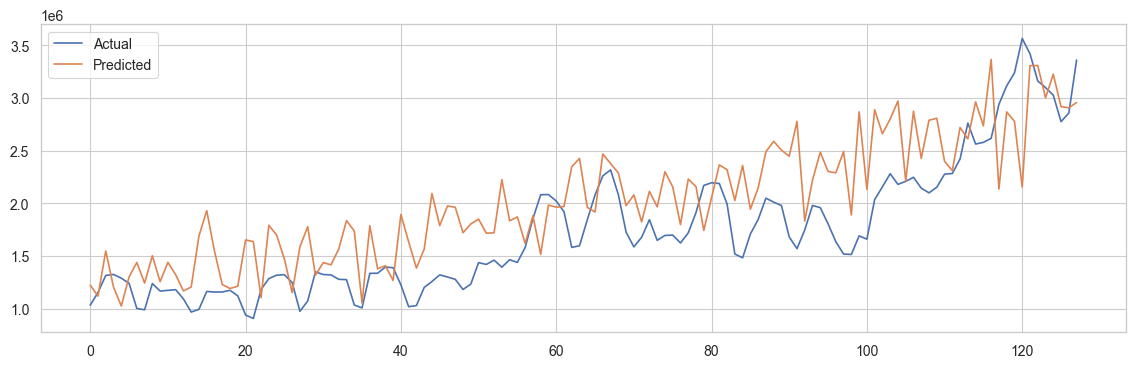

In [30]:
test_input = X_test_tensors[-1].unsqueeze(0) # transform to (1, 100, 8) (simulate batch size of 1)

test_predict_norm = lstm(test_input).reshape(-1, 1)
test_predicted = mm.inverse_transform(test_predict_norm.detach().numpy()).squeeze()

test_target_norm = y_test_tensors[-1]
test_target = mm.inverse_transform(test_target_norm.detach().numpy()).squeeze()

# Calculate the loss
test_loss = loss_fn(test_predict_norm, test_target_norm)
print("Test loss:", test_loss.item())

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(test_target, label="Actual")
ax.plot(test_predicted, label="Predicted")
ax.plot()
ax.legend()